In [17]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from einops import rearrange

## Estimating the Measure on labeling Y

We want to compute the following, but we will not be able to measure the partition function:

$\mu_K(Y) = \frac{1}{Z_K} e^{Tr(Y^TKY)}$

So instead we will measure,

$f_K(Y) = e^{Tr(Y^TKY)}$

In [125]:
#Test on generic data:
n = 300
d = 2

# Create a mixture of 2 Gaussians
mean1 = np.array([10, 10])
mean2 = np.array([-10, -10])
cov = np.array([[1, 0], [0, 1]])

data1 = np.random.multivariate_normal(mean1, cov, n // 2)
data2 = np.random.multivariate_normal(mean2, cov, n // 2)

data = np.vstack((data1, data2))

#Gaussian kernel
def k(x_i, x_j):
    return np.exp(-np.linalg.norm(x_i - x_j)**2)*100

def compute_kernel_matrix(data, k):
    n = len(data)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = k(data[i], data[j])
            
    return K

K = compute_kernel_matrix(data, k)
#K = block matrix 1 top left 1 bottom right 0 everywhere else
#K = np.zeros((n, n))
#K[:n//2, :n//2] = 1
#K[n//2:, n//2:] = 1

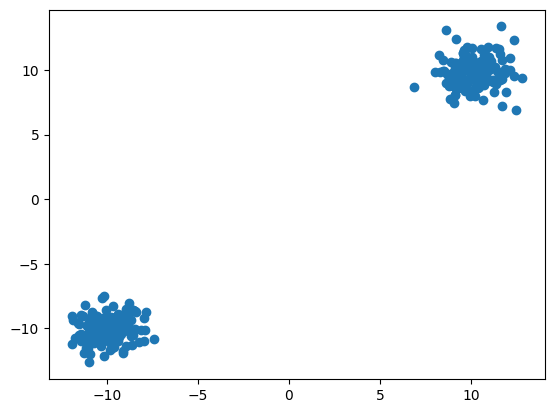

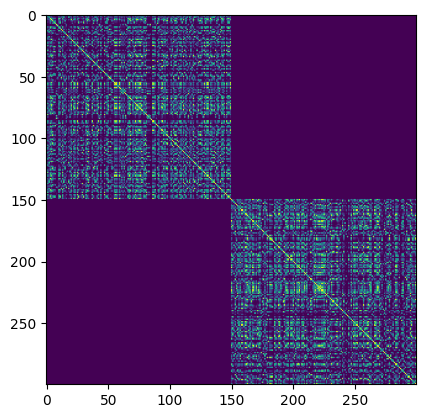

In [126]:
#plot data in r^2 space
plt.scatter(data[:, 0], data[:, 1])
#plot kernel matrix
plt.figure()
plt.imshow(K)


In [153]:
def f(K, Y):
    #return 1000 * np.exp(1000 * np.trace(np.dot(Y.T, np.dot(K, Y))))
    #return np.trace(Y @ Y.T @ K) - 100 * np.trace((np.ones((n,n)) - np.eye(n) - Y @ Y.T) @ K) 
    #return (np.trace(Y.T @ Y.T @ K) - np.trace((np.ones((n,n)) - np.eye(n) - Y @ Y.T) @ K) )
    return  0.0005 * np.trace(Y @ Y.T @ K)

In [154]:
# For Binary, for the symmetric Proposal Function we can randomly pick k in [n] and flip k random bits:
def proposal_k(Y):
    Y_new = Y.copy()
    n=len(Y)
    k = np.random.randint(n)
    i = np.random.choice(n, k, replace=False)
    Y_new[i] = 1 - Y_new[i]
    return Y_new

# We could also use a simpler proposal function, which flips a random bit:
def proposal(Y):
    Y_new = Y.copy()
    n = len(Y)
    i = np.random.randint(n)
    Y_new[i] = 1 - Y_new[i]
    return Y_new

# Metroplis-Hastings Algorithm:
def metropolis(n_iter, G_start, proposal, f, K):
    G = G_start
    n_accepted = 0
    
    # Track diagnostics
    f_values = []
    f_diffs = []
    accepted_indices = []
    
    for i in trange(n_iter):
        G_new = proposal(G)
        
        f_old = f(K, G)
        f_new = f(K, G_new)
        
        f_values.append(f_old)
        f_diffs.append(f_new - f_old)
        
        alpha = min(1, np.exp(f_new - f_old))
        
        if np.random.rand() < alpha:
            n_accepted += 1
            G = G_new
            accepted_indices.append(i)
    
    print('Acceptance rate:', n_accepted/n_iter)
    return G

Y_start = np.eye(2)[np.random.randint(2, size=(n, 1))]
Y_start = rearrange(Y_start, "x 1 z -> x z")
np.count_nonzero(proposal(Y_start) - Y_start) / 2

1.0

In [155]:
def metropolis_debug(n_iter, G_start, proposal, f, K):
    G = G_start
    n_accepted = 0
    
    # Track diagnostics
    f_values = []
    f_diffs = []
    accepted_indices = []
    
    for i in trange(n_iter):
        G_new = proposal(G)
        
        f_old = f(K, G)
        f_new = f(K, G_new)
        
        f_values.append(f_old)
        f_diffs.append(f_new - f_old)
        
        alpha = min(1, np.exp(f_new - f_old))
        
        if np.random.rand() < alpha:
            n_accepted += 1
            G = G_new
            accepted_indices.append(i)
    
    print('Acceptance rate:', n_accepted/n_iter)
    print('Average f value:', np.mean(f_values))
    print('Std of f values:', np.std(f_values))
    print('Average f diff:', np.mean(f_diffs))
    print('Std of f diffs:', np.std(f_diffs))
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Trace plot
    plt.subplot(2, 1, 1)
    plt.plot(f_values, 'b-', alpha=0.5, label='f values')
    plt.plot(accepted_indices, [f_values[i] for i in accepted_indices], 'g.', 
             alpha=0.5, label='Accepted')
    plt.xlabel('Iteration')
    plt.ylabel('f(G)')
    plt.title('MCMC Trace Plot')
    plt.legend()
    
    # Histogram of differences
    plt.subplot(2, 1, 2)
    plt.hist(f_diffs, bins=50, alpha=0.7, color='blue')
    plt.xlabel('f(G_new) - f(G)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Proposed Changes')
    
    plt.tight_layout()
    plt.show()
    
    return G

100%|██████████| 2000/2000 [00:05<00:00, 370.77it/s]


Acceptance rate: 0.4225
Average f value: 345.79522831310635
Std of f values: 64.56605107616636
Average f diff: -1.4261489069642097
Std of f diffs: 1.8350948818314359


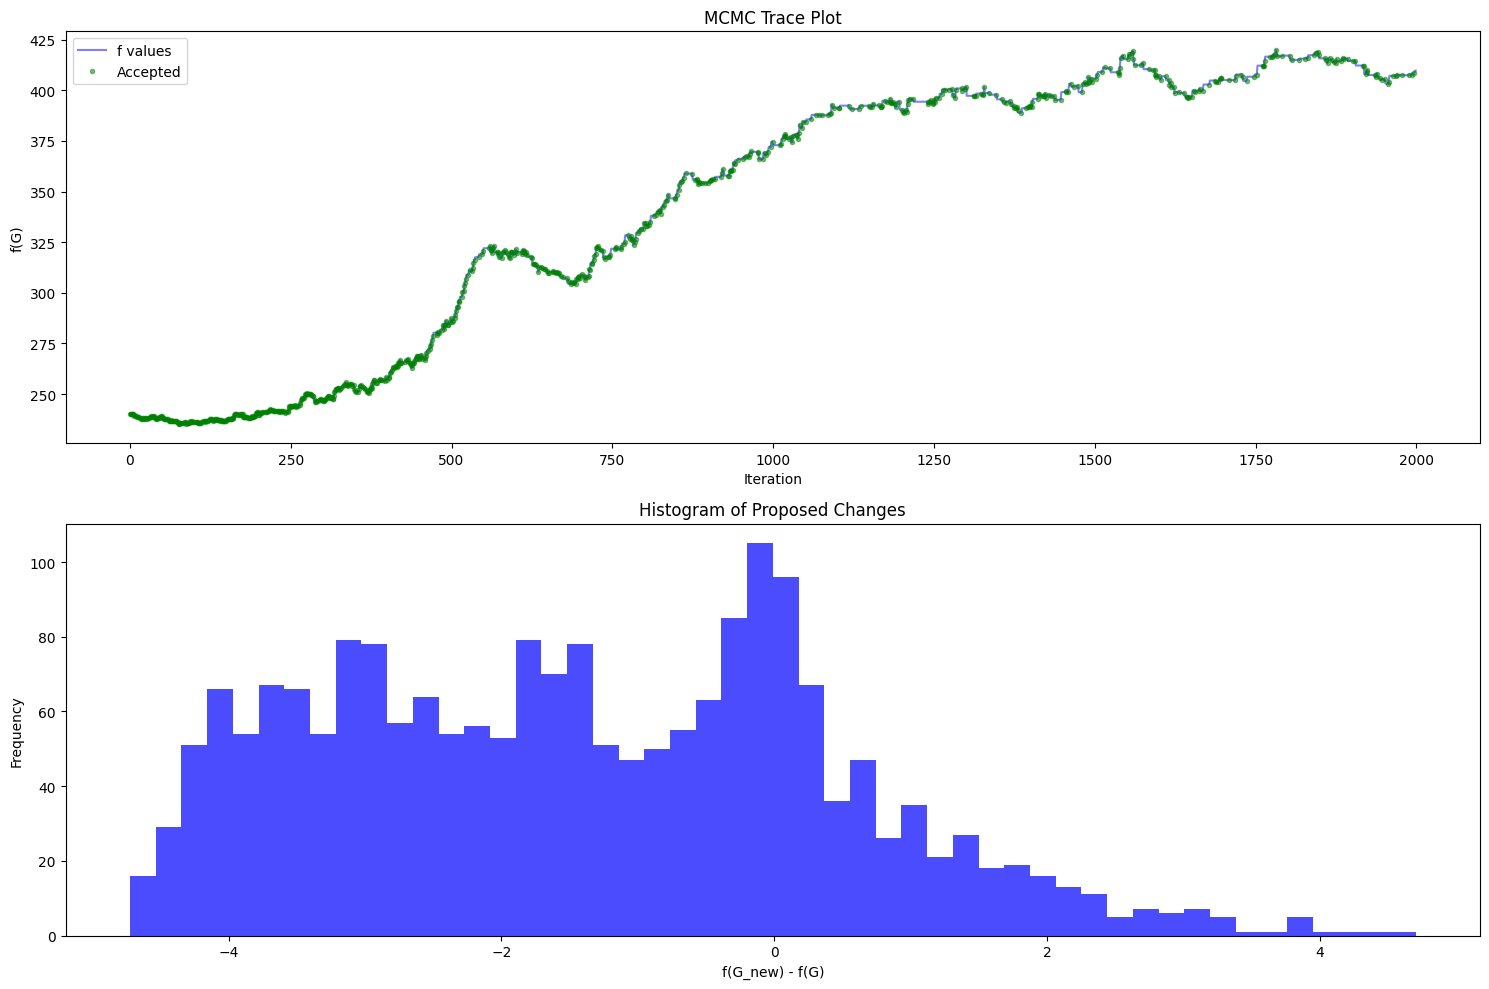

0.11333333333333333

In [156]:
Y = metropolis_debug(n_iter = 2000, G_start = Y_start, proposal = proposal, f = f, K = K)
np.count_nonzero(Y[:, 0]) / n

In [148]:
np.exp(-10)

4.5399929762484854e-05

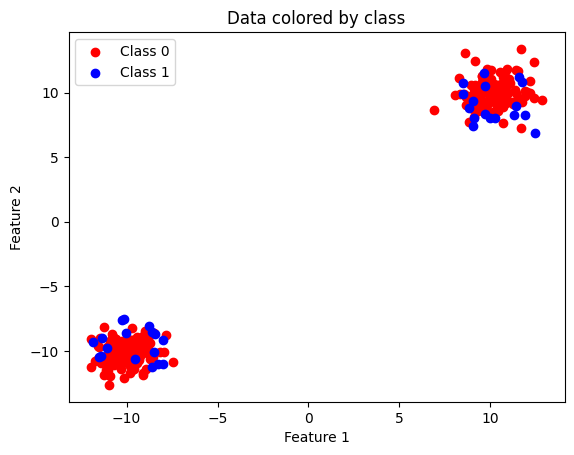

In [157]:
# Assuming Y is a binary array with values 0 or 1
Y = Y[:, 0]
plt.scatter(data[Y.flatten() == 0, 0], data[Y.flatten() == 0, 1], color='red', label='Class 0')
plt.scatter(data[Y.flatten() == 1, 0], data[Y.flatten() == 1, 1], color='blue', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Data colored by class')
plt.show()

100%|██████████| 2000/2000 [00:05<00:00, 385.06it/s]


Acceptance rate: 0.415


100%|██████████| 2000/2000 [00:05<00:00, 355.42it/s]


Acceptance rate: 0.4745


100%|██████████| 2000/2000 [00:05<00:00, 371.72it/s]


Acceptance rate: 0.558


100%|██████████| 2000/2000 [00:05<00:00, 371.96it/s]


Acceptance rate: 0.3695


100%|██████████| 2000/2000 [00:05<00:00, 367.86it/s]


Acceptance rate: 0.4615


100%|██████████| 2000/2000 [00:05<00:00, 388.97it/s]


Acceptance rate: 0.3895


100%|██████████| 2000/2000 [00:04<00:00, 452.82it/s]


Acceptance rate: 0.473


100%|██████████| 2000/2000 [00:04<00:00, 420.69it/s]


Acceptance rate: 0.4025


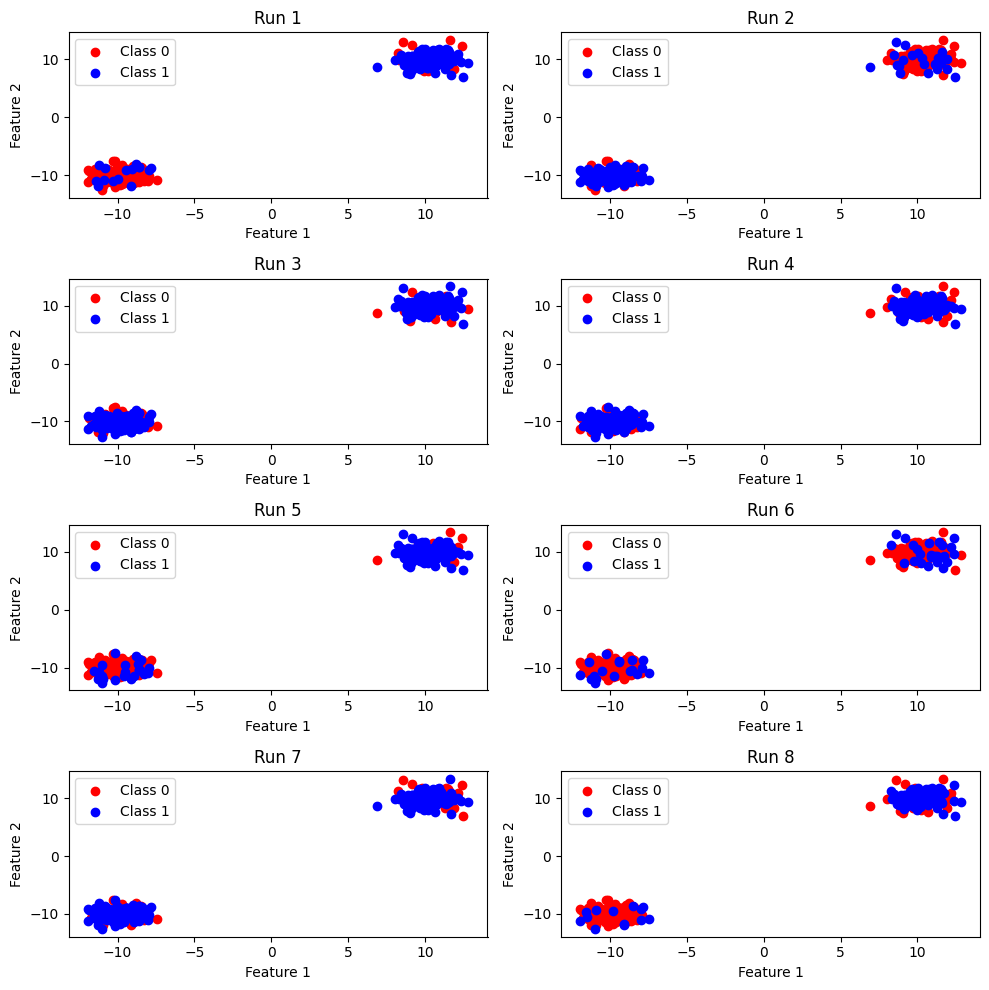

In [160]:
m = 8
fig, axes = plt.subplots(4, 2, figsize=(10, 10))

for i in range(m):
    Y_s = np.eye(2)[np.random.randint(2, size=(n, 1))]
    Y_s = rearrange(Y_s, "x 1 z -> x z")
    Y_run = metropolis(n_iter=2000, G_start=Y_s, proposal=proposal, f=f, K=K)
    Y_run = Y_run[:, 0]
    
    ax = axes[i // 2, i % 2]
    ax.scatter(data[Y_run == 0, 0], data[Y_run == 0, 1], color='red', label='Class 0')
    ax.scatter(data[Y_run == 1, 0], data[Y_run == 1, 1], color='blue', label='Class 1')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.set_title(f'Run {i+1}')

plt.tight_layout()
plt.show()


## Extend to Multi-Class

We want to do this directly on the graphs G = Y^TY to extend this most naturally to the multiclass setting. 

In [493]:
# Start with a graph adjancency matrix G_start where two nodes are connected with probability 0.5
G_start = (np.random.rand(n, n) < 0.5).astype(int)
G_start = np.triu(G_start, 1)
G_start = G_start + G_start.T + np.eye(n)
G_start

array([[1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1.],
       [0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       [0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0

In [494]:
def proposal(G):
    n = len(G)
    flip_bits = np.triu((np.random.rand(n, n) < .1).astype(int))
    G_new = G.copy()
    # element_wise xor matrix
    G_new = np.triu(np.logical_xor(flip_bits, G_new).astype(int), k = 1)
    G_new = G_new + G_new.T + np.eye(n)

    return G_new

G_new = proposal(G_start)
np.count_nonzero(G_start - G_new) / n**2

0.07111111111111111

In [522]:
def f(K, G):
    return np.trace(K @ G) * 1000
    #return np.trace(np.dot(G.T, np.dot(K, G)))

def metropolis(n_iter, G_start, proposal, f, K):
    G = G_start
    n_accepted = 0
    for _ in trange(n_iter):
        G_new = proposal(G)
        
        alpha = min(1, np.exp(f(K, G_new) - f(K, G)))
        
        if np.random.rand() < alpha: #Accept the new state
            n_accepted += 1
            G = G_new
            
    print('Acceptance rate:', n_accepted/n_iter)
    return G

def metropolis_debug(n_iter, G_start, proposal, f, K):
    G = G_start
    n_accepted = 0
    
    # Track diagnostics
    f_values = []
    f_diffs = []
    accepted_indices = []
    
    for i in trange(n_iter):
        G_new = proposal(G)
        
        f_old = f(K, G)
        f_new = f(K, G_new)
        
        f_values.append(f_old)
        f_diffs.append(f_new - f_old)
        
        alpha = min(1, np.exp(f_new - f_old))
        
        if np.random.rand() < alpha:
            n_accepted += 1
            G = G_new
            accepted_indices.append(i)
    
    print('Acceptance rate:', n_accepted/n_iter)
    print('Average f value:', np.mean(f_values))
    print('Std of f values:', np.std(f_values))
    print('Average f diff:', np.mean(f_diffs))
    print('Std of f diffs:', np.std(f_diffs))
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Trace plot
    plt.subplot(2, 1, 1)
    plt.plot(f_values, 'b-', alpha=0.5, label='f values')
    plt.plot(accepted_indices, [f_values[i] for i in accepted_indices], 'g.', 
             alpha=0.5, label='Accepted')
    plt.xlabel('Iteration')
    plt.ylabel('f(G)')
    plt.title('MCMC Trace Plot')
    plt.legend()
    
    # Histogram of differences
    plt.subplot(2, 1, 2)
    plt.hist(f_diffs, bins=50, alpha=0.7, color='blue')
    plt.xlabel('f(G_new) - f(G)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Proposed Changes')
    
    plt.tight_layout()
    plt.show()
    
    return G

G_new = metropolis_debug(n_iter = 1000, G_start = G_start, proposal = proposal, f = f, K = K)

  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 30 is different from 300)

In [279]:
G_new

array([[1., 0., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.]])

In [280]:
def factor_graph_to_onehot(G):
    """
    Factor a graph G into a one-hot matrix Y such that Y^T Y = G
    
    Parameters:
    G (np.ndarray): Input graph adjacency matrix (n x n)
    
    Returns:
    Y (np.ndarray): One-hot matrix such that Y^T Y = G
    """
    n = len(G)
    
    # Get eigendecomposition
    eigenvals, eigenvecs = np.linalg.eigh(G)
    
    # Since G is symmetric PSD, eigenvals should be non-negative
    # But due to numerical issues, we zero out tiny negative values
    eigenvals = np.maximum(eigenvals, 0)
    
    # Get rank from number of non-zero eigenvalues
    tol = 1e-10
    rank = np.sum(eigenvals > tol)
    
    # Form Y as one-hot encoding matrix
    # Y will be n x rank
    Y = np.zeros((n, rank))
    for i in range(n):
        # Find the largest magnitude component for each row
        row = eigenvecs[i, -rank:]
        max_idx = np.argmax(np.abs(row))
        Y[i, max_idx] = 1
        
    # Check if Y^T Y approximates G well
    G_reconstructed = Y @ Y.T
    error = np.linalg.norm(G - G_reconstructed)
    if error > 1e-6:
        print(f"Warning: Large reconstruction error {error:.2e}")
        
    return Y

Y = factor_graph_to_onehot(G_new)

In [287]:
np.count_nonzero(Y @ Y.T - G_new)

499582